# Machine Learning with Full 2MRS Enhanced Data

## 1. Imports

In [ ]:
#Imports
import scipy
import pandas as pd
import numpy as np
import sklearn
from pandas import read_csv
from matplotlib import pyplot as plt
import seaborn as sns
import os
from google.colab import drive

#Model-assisting import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Model imports

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Physics Research/Fall 2024 Research')

Mounted at /content/drive/


## 2. Read In and Format the Data

This includes selecting the desired columns to use, pruning the data four outliers, creating the splits, logging the densities, and normalizing the data.

In [ ]:
# Read in and visualize the data
overlap_file = read_csv('overlap_file.csv')
non_overlap_file = read_csv('only_2mrs_file.csv')

overlap_file.head()

,GalaxyID,RA,Dec,Redshift,2MRS Local Density,Distance From Filament,Distance From Tendril,SDSS Local Density,ID,l,...,r_ext,b/a,flgs,type,ts,v,e_v,c,vsrc,CAT_ID
0,25,187.70593,12.39110,0.00544,0.817944,48.499309,0.616927,4.785178,12304942+1223279,283.77777,...,2.368,0.990,Z111,-4__P,ZC,1307,7,N,2000MNRAS.313..469S,MESSIER_087
1,62,189.43166,11.81809,0.00614,0.550502,46.550675,0.463943,4.288702,12374359+1149051,290.39795,...,2.358,0.946,Z111,3X_T,ZC,1517,1,N,2008AJ....136..713K,MESSIER_058
2,139,187.25011,13.97856,0.00511,0.501012,49.493190,0.781303,2.519169,12290002+1358428,280.10791,...,2.103,0.836,0666,-4A_R,ZC,1210,16,N,1985AJ.....90.1681B,NGC_4459
3,163,187.50945,13.63645,0.00560,0.727121,48.061390,1.079201,3.191392,12300227+1338112,281.54553,...,2.172,0.960,Z111,-2B_s,ZC,1355,10,N,2002AJ....123.2990B,NGC_4477
4,345,188.02586,11.17643,0.00557,0.831199,48.103909,0.472181,3.645366,12320619+1110351,286.09946,...,2.056,0.520,0000,1,ZC,1342,23,N,1985AJ.....90.1681B,NGC_4503


In [ ]:
# Select columns

print(f'Original columns: {overlap_file.columns.tolist()}')

select = ['RA', 'Dec', 'Redshift', '2MRS Local Density', 'k_tc', 'h_tc', 'j_tc', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'SDSS Local Density']
overlap_select = overlap_file[select]

overlap_select.head()

# can add a line to create a csv based on this df if desired

Original columns: ['GalaxyID', 'RA', 'Dec', 'Redshift', '2MRS Local Density', 'Distance From Filament', 'Distance From Tendril', 'SDSS Local Density', 'ID', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']


,RA,Dec,Redshift,2MRS Local Density,k_tc,h_tc,j_tc,e_kt,e_ht,e_jt,e_bv,r_iso,r_ext,SDSS Local Density
0,187.70593,12.39110,0.00544,0.817944,5.804,6.060,6.699,0.019,0.018,0.017,0.023,2.134,2.368,4.785178
1,189.43166,11.81809,0.00614,0.550502,6.472,6.683,7.336,0.031,0.025,0.021,0.041,2.079,2.358,4.288702
2,187.25011,13.97856,0.00511,0.501012,7.136,7.375,8.065,0.011,0.010,0.008,0.045,1.967,2.103,2.519169
3,187.50945,13.63645,0.00560,0.727121,7.216,7.475,8.072,0.025,0.023,0.019,0.032,1.914,2.172,3.191392
4,188.02586,11.17643,0.00557,0.831199,7.871,8.113,8.774,0.023,0.016,0.015,0.050,1.917,2.056,3.645366


In [1]:
# Handling outliers using IQR Method

# Calculate IQR for SDSS
Q1_sdss = overlap_select['SDSS Local Density'].quantile(0.25)
Q3_sdss = overlap_select['SDSS Local Density'].quantile(0.75)
IQR_sdss = Q3_sdss - Q1_sdss

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound_sdss = Q1_sdss - 1.5 * IQR_sdss
upper_bound_sdss = Q3_sdss + 1.5 * IQR_sdss

# Calculate IQR for 2MRS
Q1_2mrs = overlap_select['2MRS Local Density'].quantile(0.25)
Q3_2mrs = overlap_select['2MRS Local Density'].quantile(0.75)
IQR_2mrs = Q3_2mrs - Q1_2mrs

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound_2mrs = Q1_2mrs - 1.5 * IQR_2mrs
upper_bound_2mrs = Q3_2mrs + 1.5 * IQR_2mrs

# Identify SDSS outliers
outliers_iqr_sdss = overlap_select[(overlap_select['SDSS Local Density'] < lower_bound_sdss) |
                           (overlap_select['SDSS Local Density'] > upper_bound_sdss)]
print(f'SDSS Outliers Shape: {outliers_iqr_sdss.shape}')

# Identify 2MRS outliers
outliers_iqr_2mrs = overlap_select[(overlap_select['2MRS Local Density'] < lower_bound_2mrs) |
                           (overlap_select['2MRS Local Density'] > upper_bound_2mrs)]
print(f'2MRS Outliers Shape: {outliers_iqr_2mrs.shape}')

# Creating the pruned data based on both local desnity features
pruned_overlap  = overlap_select[(overlap_select['SDSS Local Density'] >= lower_bound_sdss) &
                                (overlap_select['SDSS Local Density'] <= upper_bound_sdss) &
                                (overlap_select['2MRS Local Density'] >= lower_bound_2mrs) &
                                (overlap_select['2MRS Local Density'] <= upper_bound_2mrs)]

print(f'Pruned Dataset Shape: {pruned_overlap.shape}')

NameError: name 'overlap_select' is not defined

In [ ]:
pruned_overlap.head()

,RA,Dec,Redshift,2MRS Local Density,k_tc,h_tc,j_tc,e_kt,e_ht,e_jt,e_bv,r_iso,r_ext,SDSS Local Density
136,183.97717,6.40111,0.00797,0.058873,9.060,9.290,9.973,0.024,0.015,0.014,0.017,1.684,1.840,5.816617
138,184.35759,6.69003,0.00856,0.061600,9.016,9.294,9.993,0.040,0.027,0.025,0.023,1.762,1.912,4.468965
141,184.73404,4.78598,0.00775,0.065681,9.483,9.715,10.405,0.027,0.016,0.016,0.020,1.559,1.727,6.734374
142,185.42279,5.38483,0.00871,0.025702,9.523,9.767,10.417,0.034,0.020,0.020,0.022,1.732,1.884,13.975354
143,185.31866,4.59568,0.00868,0.021946,9.544,9.740,10.376,0.041,0.024,0.023,0.021,1.627,1.798,6.548093


In [ ]:
pruned_overlap.describe()

,RA,Dec,Redshift,2MRS Local Density,k_tc,h_tc,j_tc,e_kt,e_ht,e_jt,e_bv,r_iso,r_ext,SDSS Local Density
count,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000,2636.000000
mean,181.083559,26.321026,0.021101,0.031213,10.692675,10.965865,11.651777,0.046982,0.036618,0.030286,0.023829,1.348325,1.586580,2.088261
std,23.372910,16.258512,0.007598,0.030540,0.779486,0.785235,0.789128,0.017247,0.014277,0.011931,0.012132,0.187283,0.163564,3.075896
min,140.007660,0.060880,0.005010,0.001462,6.055000,6.305000,7.148000,0.008000,0.006000,0.004000,0.003000,0.914000,1.244000,0.012160
25%,161.995583,12.549848,0.015660,0.010144,10.366250,10.639250,11.327000,0.035000,0.027000,0.023000,0.016000,1.217000,1.476000,0.286632
50%,181.787605,25.359975,0.023050,0.020238,10.877500,11.158000,11.849000,0.045000,0.035000,0.029000,0.022000,1.318000,1.563000,0.733216
75%,201.895013,38.234255,0.026788,0.040237,11.254000,11.514000,12.200250,0.057000,0.044000,0.036000,0.029000,1.449000,1.668250,2.395183
max,219.967450,59.976460,0.032990,0.153854,11.712000,12.220000,13.007000,0.167000,0.228000,0.216000,0.166000,2.281000,2.513000,15.859787


In [ ]:
# Creating the splits

vals = pruned_overlap.values

log_data = np.copy(vals)
log_data[:, 4] = np.log(vals[:, 4])  # Transforms 2MRS Local Density values
log_data[:, -1] = np.log(vals[:, -1])  # Transform SDSS Local Density values

X = log_data[:, 0:-1] # All columns except SDSS Local Density
y = log_data[:, -1] # SDSS Local Density (logged)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [ ]:
# Range of SDSS densities when logged
print(f'Min: {np.min(y)}')
print(f'Max: {np.max(y)}')

Min: -4.4095993155976725
Max: 2.7637867918135224


In [ ]:
# Normalizing the data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

# Fit and transform the data
scaler.fit(X_train)
X_train_sscaled = scaler.transform(X_train)
X_test_sscaled = scaler.transform(X_test)

## 3. Cross-Validation & Model Prediction

In [ ]:
# K-Fold Cross-Validation To Compare Models

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5))) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model RMSEs:\n')
for name, model in models:
  kfold = KFold(n_splits=5, random_state=15, shuffle=True)
  cvResult = cross_val_score(model, X_train_sscaled, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}')

print('\nModel R^2s:\n')
for name, model in models:
  kfold = KFold(n_splits=5, random_state=15, shuffle=True)
  cvResult = cross_val_score(model, X_train_sscaled, y_train, cv=kfold, scoring='r2')
  print(f'{name}: {round(cvResult.mean(), 2)}')

Model RMSEs:

LR: 1.32
RFR: 1.24
KNN: 1.41
GBR: 1.28
SVM: 1.33

Model R^2s:

LR: 0.14
RFR: 0.23
KNN: 0.02
GBR: 0.19
SVM: 0.13


In [ ]:
# Predicting with RFR
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train_sscaled, y_train)
predictions = model_rfr.predict(X_test_sscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, predictions)}\n')
print(f'R^2 Score: {r2_score(y_test, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(y_test, predictions), 2)}%\n')

Root Mean Squared Error: 1.2274974564480032

R^2 Score: 0.2718036441804248

MAPE Score: 2.06%



Importances: [0.10895084 0.09821772 0.12860612 0.24017569 0.03841969 0.04721421
 0.0436733  0.05071859 0.03897517 0.03912343 0.0643806  0.05081147
 0.05073317]


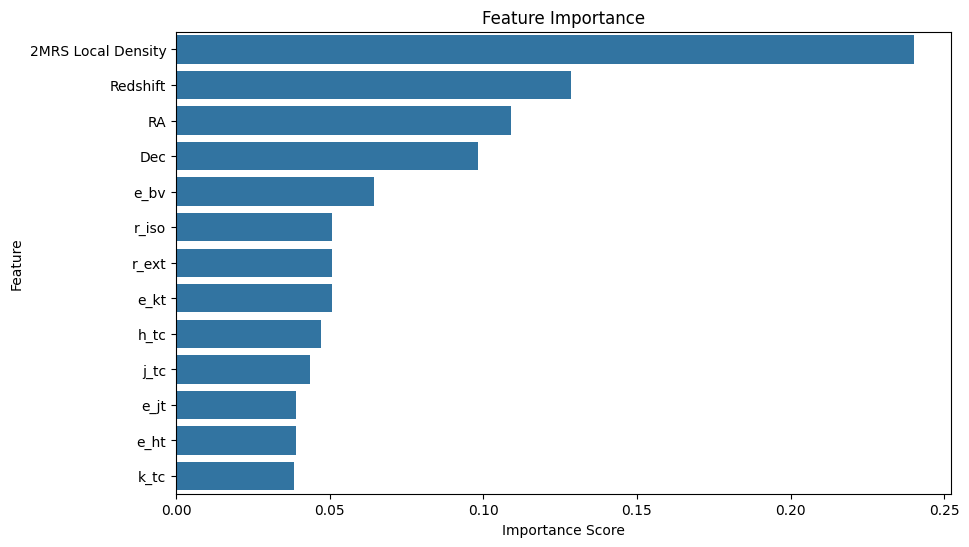

In [ ]:
import seaborn as sns

# Extract feature importances
importances = model_rfr.feature_importances_

print(f'Importances: {importances}')

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': select[:-1],
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## Visualizing Prediction Errors

In [ ]:
residuals = y_test - predictions

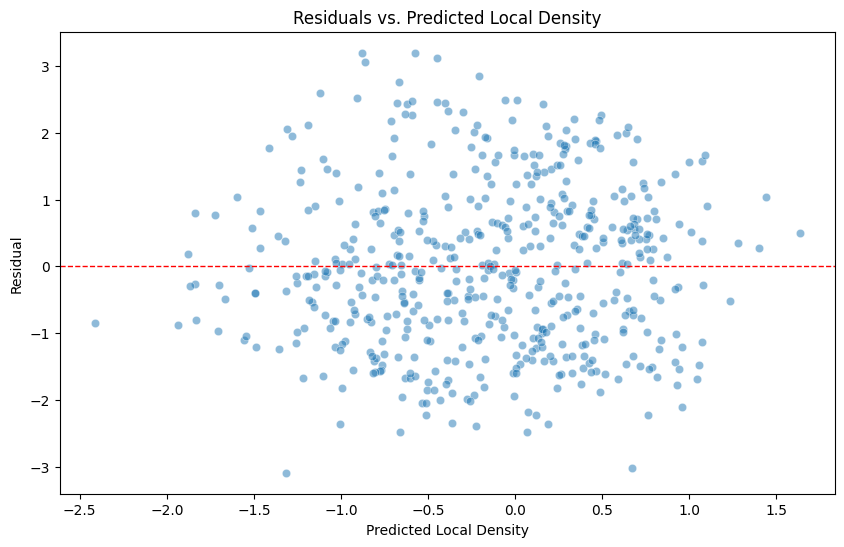

In [ ]:
# Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Local Density')
plt.ylabel('Residual')
plt.title('Residuals vs. Predicted Local Density')
plt.show()

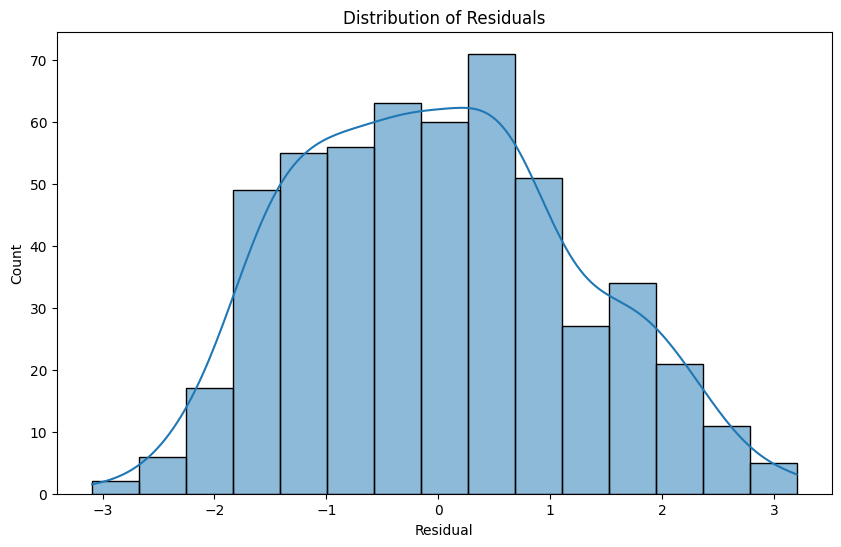

In [ ]:
# Error Plot Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual')
plt.title('Distribution of Residuals')
plt.show()

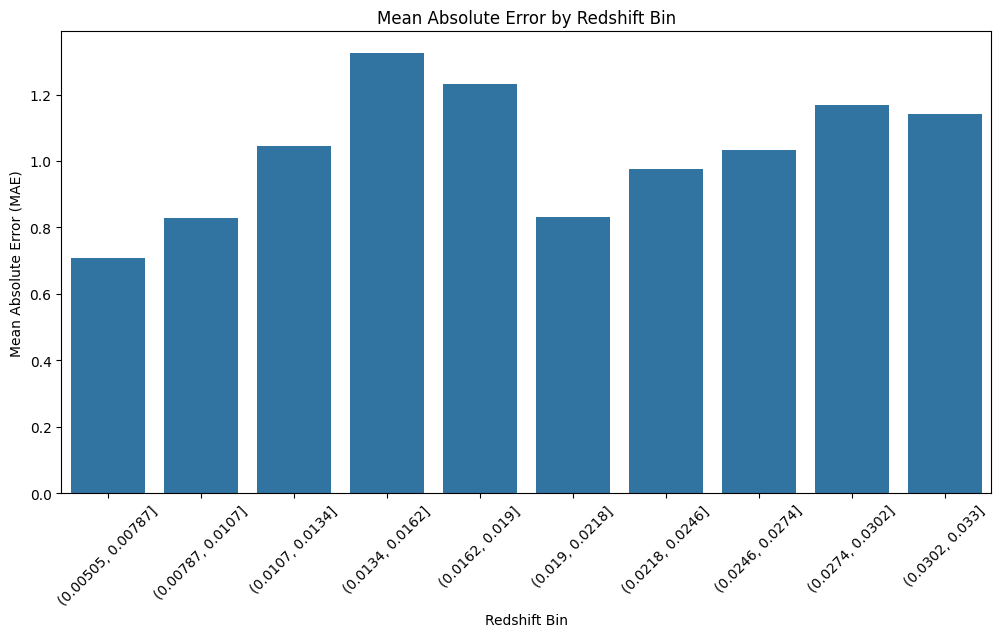

In [ ]:
# Error vs. Redshift

# Define redshift bins
redshift_bins = pd.cut(X_test[:, 2], bins=10) #Redshift is column 2
df = pd.DataFrame({'redshift_bin': redshift_bins, 'residual': residuals})

# Calculate Mean Absolute Error (MAE) per bin
error_by_redshift = df.groupby('redshift_bin', observed=True)['residual'].apply(lambda x: np.abs(x).mean()).reset_index()

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='redshift_bin', y='residual', data=error_by_redshift)
plt.xticks(rotation=45)
plt.xlabel('Redshift Bin')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Mean Absolute Error by Redshift Bin')
plt.show()

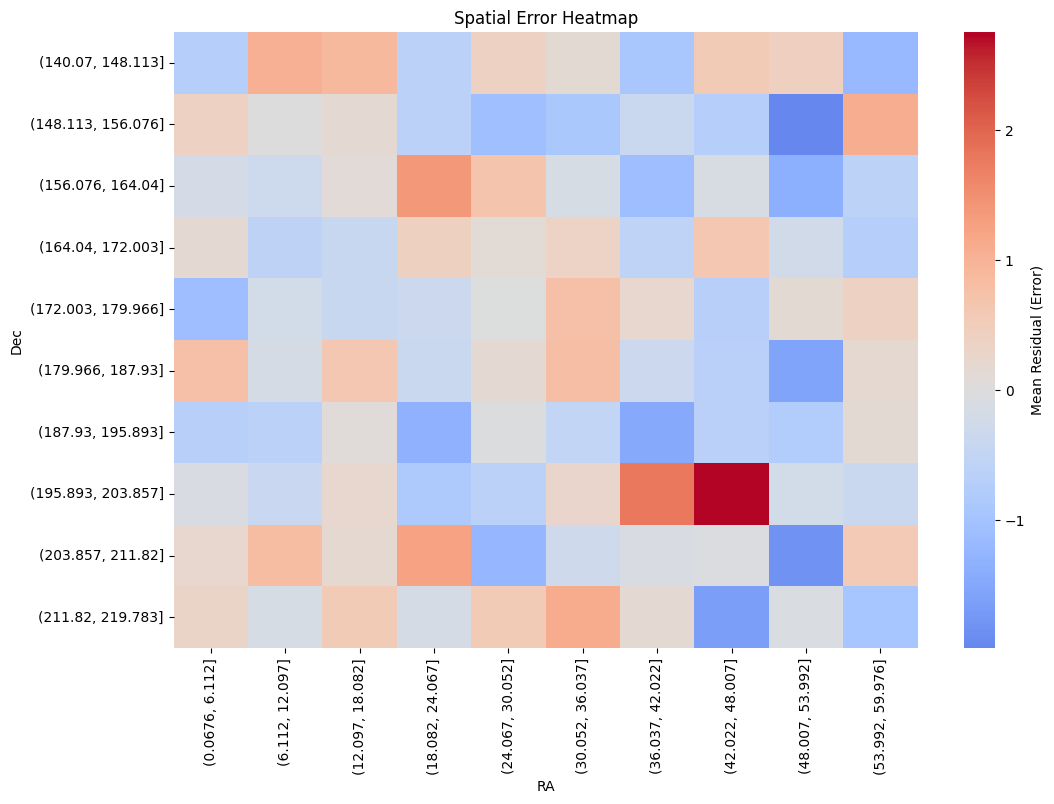

In [ ]:
# Heatmap of Spacial Errors

# Bin RA and Dec
ra_bins = pd.cut(X_test[:, 0], bins=10) #RA is column 0
dec_bins = pd.cut(X_test[:, 1], bins=10) #Dec is column 1
df = pd.DataFrame({'RA_bin': ra_bins, 'Dec_bin': dec_bins, 'residual': residuals})

# Calculate mean residual for each spatial bin
error_map = df.groupby(['RA_bin', 'Dec_bin'], observed=False)['residual'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(error_map, cmap='coolwarm', center=0, cbar_kws={'label': 'Mean Residual (Error)'})
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Spatial Error Heatmap')
plt.show()

## Using Power Transformations

In [ ]:
# Creating the splits

vals = pruned_overlap.values

X = vals[:, 0:-1] # All columns except SDSS Local Density
y = vals[:, -1] # SDSS Local Density

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [ ]:
# Normalizing the data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

# Fit and transform the data
scaler.fit(X_train)
X_train_sscaled = scaler.transform(X_train)
X_test_sscaled = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson')

X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

In [ ]:
# K-Fold Cross-Validation To Compare Models

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5))) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model RMSEs:\n')
for name, model in models:
  kfold = KFold(n_splits=5, random_state=15, shuffle=True)
  cvResult = cross_val_score(model, X_train_transformed, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}')

print('\nModel R^2s:\n')
for name, model in models:
  kfold = KFold(n_splits=5, random_state=15, shuffle=True)
  cvResult = cross_val_score(model, X_train_transformed, y_train, cv=kfold, scoring='r2')
  print(f'{name}: {round(cvResult.mean(), 2)}')

Model RMSEs:

LR: 2.97
RFR: 3.01
KNN: 3.24
GBR: 3.01
SVM: 3.18

Model R^2s:

LR: 0.05
RFR: 0.03
KNN: -0.13
GBR: 0.02
SVM: -0.08


The metrics got worse; it appears that logging is the way to go.

## Trying a Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

In [ ]:
# Creating the splits

vals = pruned_overlap.values

log_data = np.copy(vals)
log_data[:, 4] = np.log(vals[:, 4])  # Transforms 2MRS Local Density values
log_data[:, -1] = np.log(vals[:, -1])  # Transform SDSS Local Density values

X = log_data[:, 0:-1] # All columns except SDSS Local Density
y = log_data[:, -1] # SDSS Local Density (logged)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [ ]:
# Normalizing the data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

# Fit and transform the data
scaler.fit(X_train)
X_train_sscaled = scaler.transform(X_train)
X_test_sscaled = scaler.transform(X_test)

In [ ]:
# Initialize the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(20, 12),  # Two hidden layers with 50 and 30 neurons
                   max_iter=150,
                   activation='relu',
                   solver='adam',
                   random_state=15)

In [ ]:
# Cross validation with neural network

from sklearn.model_selection import cross_validate

# Perform cross-validation with multiple scoring metrics
cv_results = cross_validate(mlp, X_train_sscaled, y_train, cv=5,
                            scoring=['neg_mean_squared_error', 'r2'],
                            return_train_score=True)

# Convert negative MSE to positive
mse_scores = -cv_results['test_neg_mean_squared_error']
print(f"Cross-Validation MSE Scores: {mse_scores}")
print(f"Mean MSE: {np.mean(mse_scores):.2f}")
print(f"R^2 Scores: {cv_results['test_r2']}")
print(f"Mean R^2 Score: {np.mean(cv_results['test_r2']):.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-Validation MSE Scores: [1.62586932 1.85828641 1.63529229 1.95807566 1.70672604]
Mean MSE: 1.76
R^2 Scores: [0.14382526 0.04273142 0.16869737 0.15377951 0.17527155]
Mean R^2 Score: 0.14


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Initialize the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(20, 8),  # Two hidden layers with 50 and 30 neurons
                   max_iter=150,
                   activation='relu',
                   solver='adam',
                   random_state=15)

# Train the model
mlp.fit(X_train_sscaled, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_sscaled)

# Evaluate with Mean Squared Error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"Test R^2 Score: {r2:.3f}")

Test RMSE: 1.28
Test R^2 Score: 0.208


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
